# **UTILS**

In [ ]:
import os


!unzip /content/drive/MyDrive/img_resized.zip
!unzip /content/drive/MyDrive/img_txt.zip
print(len(os.listdir('/content/img_resized')))
print(len(os.listdir('/content/img_txt')))
!cp /content/drive/MyDrive/hate_speech/hate_speech_data/MMHS150K_GT.json /content

Streaming output truncated to the last 5000 lines.
  inflating: img_txt/1116707352294625281.json  
  inflating: __MACOSX/img_txt/._1116707352294625281.json  
  inflating: img_txt/1115320062158700553.json  
  inflating: __MACOSX/img_txt/._1115320062158700553.json  
  inflating: img_txt/1117667085453332480.json  
  inflating: __MACOSX/img_txt/._1117667085453332480.json  
  inflating: img_txt/1115381893665644544.json  
  inflating: __MACOSX/img_txt/._1115381893665644544.json  
  inflating: img_txt/1044014550612414466.json  
  inflating: __MACOSX/img_txt/._1044014550612414466.json  
  inflating: img_txt/1044681944301211651.json  
  inflating: __MACOSX/img_txt/._1044681944301211651.json  
  inflating: img_txt/1106567011994222593.json  
  inflating: __MACOSX/img_txt/._1106567011994222593.json  
  inflating: img_txt/1116647153479319552.json  
  inflating: __MACOSX/img_txt/._1116647153479319552.json  
  inflating: img_txt/1061078709917175808.json  
  inflating: __MACOSX/img_txt/._1061078709917

# **DEPENDENCIES**

In [ ]:
!pip install easyocr tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 30.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 813.9/813.9 kB 55.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.0/146.0 kB 17.3 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import pandas as pd
import torchvision.models as models
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn.functional as F
import torch.optim as optim
import re
from PIL import Image
from torchtext.vocab import GloVe
from torch.utils.data import random_split
import easyocr
import cv2
import json
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.metrics import f1_score, roc_auc_score
from torch.nn.utils.rnn import pad_sequence
import random
from tqdm import tqdm
random.seed(42)
UNK_PROPORTION = 0.01

In [ ]:
reader = easyocr.Reader(['en'])
glove_embeddings = GloVe(name='twitter.27B', dim=100)
nltk.download('wordnet')
nltk.download('punkt')
lemmatizer = WordNetLemmatizer()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

.vector_cache/glove.twitter.27B.zip: 1.52GB [11:41, 2.17MB/s]                            
100%|█████████▉| 1193513/1193514 [00:59<00:00, 20022.27it/s]
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
unk_embedding = torch.mean(glove_embeddings.vectors, dim=0)
glove_embeddings.itos.append('<unk>')
glove_embeddings.stoi['<unk>'] = len(glove_embeddings.itos) - 1
glove_embeddings.vectors = torch.cat([glove_embeddings.vectors, unk_embedding.unsqueeze(0)], dim=0)

In [ ]:
glove_embeddings.vectors.shape

torch.Size([1193515, 100])

In [ ]:
def get_ocr_text(image_path):

    text_data = []
    # Read an image
    image = cv2.imread(image_path)

    # Perform OCR on the image
    result = reader.readtext(image)
    for (bbox, text, prob) in result:
        text_data.append(text)


    sentence = ' '.join(text_data)
    print(sentence)
    # image = cv2.imread(test_file)
    # cv2_imshow(image)
    return sentence

# **DATA ANALYSIS**

# **DATA LOADER**

In [ ]:
image_transform = transforms.Compose([
    transforms.Resize(500),
    transforms.RandomCrop(299),
    transforms.RandomHorizontalFlip(),
    transforms.Lambda(lambda x: x.convert("RGB")),  # Convert grayscale to RGB
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the image
])


def remove_url(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    no_url_text = url_pattern.sub(r'', text)
    return no_url_text

def pad_collate(batch):
    (img, text, ocr_text, label) = zip(*batch)

    img = torch.stack(img)
    label = torch.stack(label)

    text_pad = pad_sequence([t for t in text], batch_first=True, padding_value=0)
    ocr_text_pad = pad_sequence([o for o in ocr_text], batch_first=True, padding_value=0)

    return img, text_pad, ocr_text_pad, label


def load_dataset(file_path):
    # Load data
    with open(file_path, 'r') as f:
        data_dict = json.load(f)
    print(len(data_dict))
    # Process data and create examples
    data = {'id': [], 'text': [], 'label': []}
    for key, value in data_dict.items():
        # append the key to the 'id' list
        data['id'].append(key)
        text = remove_url(value['tweet_text'])  # Assuming remove_url is a function you've defined elsewhere
        label_list = [1 if num != 0 else 0 for num in value['labels']]
        label = max(set(label_list), key=label_list.count)
        data['text'].append(text)
        data['label'].append(label)

    # Create DataFrame
    df = pd.DataFrame(data)

    return df


def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'@\w+', '@USER', text)   # Replace usernames
    text = re.sub(r'#\w+', '#HASHTAG', text)  # Replace hashtags
    words = word_tokenize(text)
    words = [lemmatizer.lemmatize(word) for word in words]  # Lemmatize words
    words = ['<unk>' if random.random() < UNK_PROPORTION else word for word in words]  # Replace a proportion of words with <unk>
    return ' '.join(words)

def transform_text(preprocessed_text):
    text = preprocess_text(preprocessed_text)
    vectorized_text = []
    if text.strip():  # check if text is not empty or not just whitespace
        for word in text.split():
            if word in glove_embeddings.stoi:
                vectorized_text.append(glove_embeddings.vectors[glove_embeddings.stoi[word]])
            else:
                vectorized_text.append(glove_embeddings.vectors[glove_embeddings.stoi['<unk>']])  # Use <unk> embedding for unseen words
        vectorized_text = torch.stack(vectorized_text)
    else:
        vectorized_text = torch.zeros((1, glove_embeddings.vectors.shape[1]))  # return tensor with shape (1, embedding_dim) with zeros

    return vectorized_text

In [ ]:
data = load_dataset('/content/MMHS150K_GT.json')

149823


In [ ]:
class FCM_Dataset(Dataset):
    def __init__(self, dataframe, img_dir, ocr_dir, text_transform=None, img_transform=None):
        """
        Args:
            dataframe (pandas.DataFrame): A pandas dataframe with columns ['id', 'text', 'label'].
            img_dir (str): Directory with all the images.
            ocr_dir (str): Directory with all the OCR text json files.
            text_transform (callable, optional): Optional transform to be applied on the text data.
            img_transform (callable, optional): Optional transform to be applied on the image data.
        """
        self.df = dataframe
        self.img_dir = img_dir
        self.ocr_dir = ocr_dir
        self.text_transform = text_transform
        self.img_transform = img_transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.img_dir, f"{self.df.iloc[idx, 0]}.jpg")
        img = Image.open(img_name)

        if self.img_transform:
            img = self.img_transform(img)

        ocr_file = os.path.join(self.ocr_dir, f"{self.df.iloc[idx, 0]}.json")
        if os.path.exists(ocr_file):
            with open(ocr_file, 'r') as f:
                ocr_data = json.load(f)
                ocr_text = ocr_data['img_text']
        else:
            ocr_text = ""  # if no OCR text available, set it to empty string

        text = self.df.iloc[idx, 1]

        if self.text_transform:
            text = self.text_transform(text)
            ocr_text = self.text_transform(ocr_text)

        label = self.df.iloc[idx, 2]

        return img, text, ocr_text, torch.tensor(label, dtype=torch.long)


In [ ]:
# Assuming you have your dataframe, image directory and ocr text directory
image_directory = '/content/img_resized'
ocr_text_directory = '/content/img_txt'

# Create dataset
fcm_dataset = FCM_Dataset(data, image_directory, ocr_text_directory, img_transform=image_transform,text_transform=transform_text)

# Get the lengths of splits
total_len = len(fcm_dataset)
print(total_len)
train_len = int(0.7 * total_len)
val_len = int(0.2 * total_len)
test_len = total_len - train_len - val_len  # Assign remaining data to test set

# Create random splits
train_data, val_data, test_data = random_split(fcm_dataset, lengths=[train_len, val_len, test_len])

# Create DataLoaders for each split
train_dataloader = DataLoader(train_data, batch_size=10, shuffle=True, num_workers=0, collate_fn=pad_collate)
val_dataloader = DataLoader(val_data, batch_size=10, shuffle=True, num_workers=0, collate_fn=pad_collate)
test_dataloader = DataLoader(test_data, batch_size=10, shuffle=True, num_workers=0, collate_fn=pad_collate)


149823


In [ ]:
for img, text, ocr, label in train_dataloader:
    print("Image shape: ", img.shape)
    print("Text: ", text.shape)
    print("OCR: ", ocr.shape)
    print("Label: ", label)
    break

Image shape:  torch.Size([10, 3, 224, 224])
Text:  torch.Size([10, 19, 100])
OCR:  torch.Size([10, 59, 100])
Label:  tensor([1, 0, 0, 0, 0, 0, 0, 0, 1, 0])


# **TEXT MODEL - LSTM**

In [ ]:
EMBEDDING_DIM = 100
HIDDEN_DIM = 150
N_LAYERS = 1
DROPOUT = 0.25

class TextFeatureExtractor(nn.Module):
    def __init__(self, embedding_dim, hidden_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.fc1 = nn.Linear(2*hidden_dim, 150)
        self.dropout = nn.Dropout(DROPOUT)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        # We concatenate the final forward (lstm_out[:, -1, :self.hidden_dim]) and backward (lstm_out[:, 0, self.hidden_dim:]) hidden layer outputs
        lstm_out = torch.cat((lstm_out[:, -1, :self.hidden_dim], lstm_out[:, 0, self.hidden_dim:]), dim=1)
        lstm_out = self.dropout(lstm_out)
        fc_out = self.fc1(lstm_out)
        return fc_out

In [ ]:
textFeatureExtractorModel = TextFeatureExtractor(EMBEDDING_DIM, HIDDEN_DIM,).to(device)

In [ ]:
pretrained_dict = torch.load("model_state_dict.pth", map_location=torch.device('cpu'))
textFeatureExtractorModel_dict = textFeatureExtractorModel.state_dict()
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in textFeatureExtractorModel_dict}
textFeatureExtractorModel_dict.update(pretrained_dict)
textFeatureExtractorModel.load_state_dict(textFeatureExtractorModel_dict)

<All keys matched successfully>

# **IMAGE MODEL - INCEPTION**

In [ ]:
# Load the pre-trained weights of the Inception v3 model
inception = models.inception_v3(weights="Inception_V3_Weights.IMAGENET1K_V1", transform_input=False).to(device)
inception.fc = nn.Identity()

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:03<00:00, 35.6MB/s]


# **FCM MODEL**

In [ ]:
class FCModel(nn.Module):
    def __init__(self, text_model, image_model):
        super().__init__()
        self.text_model = text_model
        self.image_model = image_model
        self.fc1 = nn.Linear(2348, 1024)
        self.bn1 = nn.BatchNorm1d(1024)  # BatchNorm after fc1
        self.fc2 = nn.Linear(1024, 512)
        self.bn2 = nn.BatchNorm1d(512)  # BatchNorm after fc2
        self.out = nn.Linear(512, 2)

        # Initialize weights and bias
        nn.init.kaiming_normal_(self.fc1.weight)
        nn.init.constant_(self.fc1.bias, 0)

        nn.init.kaiming_normal_(self.fc2.weight)
        nn.init.constant_(self.fc2.bias, 0)

        nn.init.kaiming_normal_(self.out.weight)
        nn.init.constant_(self.out.bias, 0)

    def forward(self, img_in, text_in, ocr_text_in):
        img_in = self.image_model(img_in)  # (B, 2048)
        text_in = self.text_model(text_in)  # (B, 150)
        ocr_text_in = self.text_model(ocr_text_in)  # (B, 150)

        if self.training:
            x = torch.cat((img_in.logits, ocr_text_in, text_in), dim=1)  # (B, 2348)
        else:
             x = torch.cat((img_in, ocr_text_in, text_in), dim=1)  # (B, 2348)

        x = F.relu(self.bn1(self.fc1(x)))  # Use ReLU after BatchNorm and fc1
        x = F.relu(self.bn2(self.fc2(x)))  # Use ReLU after BatchNorm and fc2
        x = self.out(x)

        return x

In [ ]:
model = FCModel(textFeatureExtractorModel, inception).to(device)

In [ ]:
class_weights = [1 / 75.327553, 1 / 24.672447]
class_weights = torch.tensor(class_weights)
class_weights = class_weights / class_weights.sum()
class_weights = class_weights.to(device)


In [ ]:
# Define loss function
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# (Optional) Define learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [ ]:
def validate_model(model, dataloader, criterion):
    model.eval()
    running_loss = 0
    correct_predictions = 0
    all_preds = []
    all_labels = []

    val_loop = tqdm(enumerate(dataloader), total=len(dataloader), leave=True, position=0)

    with torch.no_grad():
        for i, (img, text, text_ocr, labels) in val_loop:
            img = img.to(device)
            text = text.to(device)
            text_ocr = text_ocr.to(device)
            labels = labels.to(device)
            outputs = model(img, text, text_ocr)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * img.size(0)
            _, preds = torch.max(outputs, 1)
            correct_predictions += (preds == labels.data).sum().item()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            val_loop.set_postfix({'validation_loss': '{:.3f}'.format(loss.item()/len(labels)),
                                  'validation_acc': '{:.3f}'.format(correct_predictions/(len(all_preds)))})

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = correct_predictions / len(dataloader.dataset)
    val_f1 = f1_score(all_labels, all_preds)
    val_auc = roc_auc_score(all_labels, all_preds)

    return epoch_loss, epoch_acc, val_f1, val_auc


def train_model(model, dataloader, optimizer, criterion):
    model.train()
    running_loss = 0
    correct_predictions = 0

    train_loop = tqdm(enumerate(dataloader), total=len(dataloader), leave=True, position=0)

    for i, (img, text, text_ocr, labels) in train_loop:
        img = img.to(device)
        text = text.to(device)
        text_ocr = text_ocr.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(img, text, text_ocr)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * img.size(0)
        _, preds = torch.max(outputs, 1)
        correct_predictions += (preds == labels.data).sum().item()

        train_loop.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(labels)),
                                'training_acc': '{:.3f}'.format(correct_predictions/((i+1)*len(labels)))})

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = correct_predictions / len(dataloader.dataset)

    return epoch_loss, epoch_acc


In [ ]:
train_loss_data = []
train_acc_data = []
val_loss_data = []
val_acc_data = []
val_f1_data = []
val_auc_data = []

In [ ]:
EPOCHS = 10  # Set the number of epochs

# Variables for tracking best validation loss
best_val_loss = float('inf')
best_model = None

for epoch in range(EPOCHS):
    print(f'Starting epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    # Train the model
    train_loss, train_acc = train_model(model, train_dataloader, optimizer, criterion)
    train_loss_data.append(train_loss)
    train_acc_data.append(train_acc)
    print(f'\nTrain loss {train_loss}, accuracy {train_acc}')

    # Validate the model
    val_loss, val_acc, val_f1, val_auc = validate_model(model, val_dataloader, criterion)
    val_loss_data.append( val_loss)
    val_acc_data.append(val_acc)
    val_f1_data.append(val_f1)
    val_auc_data.append(val_auc)
    print(f'\nValidation loss {val_loss}, accuracy {val_acc}, F1 {val_f1}, AUC {val_auc}')

    # Check if this model is the best so far
    if val_loss < best_val_loss:
        print(f'New best model found (validation loss decreased from {best_val_loss} to {val_loss})')
        best_val_loss = val_loss
        best_model = model.state_dict()  # Save the model parameters


    scheduler.step()

print('Training complete.')

Starting epoch 1/10
----------


100%|██████████| 10488/10488 [35:01<00:00,  4.99it/s, training_loss=0.050, training_acc=1.373]



Train loss 0.46843066395356053, accuracy 0.8238014417025821


100%|██████████| 2997/2997 [04:26<00:00, 11.24it/s, validation_loss=0.036, validation_acc=0.871]



Validation loss 0.5671383232492946, accuracy 0.8711120010679482, F1 0.7254372245130101, AUC 0.8129066932244797
New best model found (validation loss decreased from inf to 0.5671383232492946)
Starting epoch 2/10
----------


100%|██████████| 10488/10488 [34:44<00:00,  5.03it/s, training_loss=0.080, training_acc=1.409]



Train loss 0.43081502467800237, accuracy 0.8452934894542126


100%|██████████| 2997/2997 [04:27<00:00, 11.21it/s, validation_loss=0.231, validation_acc=0.850]



Validation loss 0.40834801680986654, accuracy 0.8499866506474436, F1 0.7218612709609555, AUC 0.8329325612086192
New best model found (validation loss decreased from 0.5671383232492946 to 0.40834801680986654)
Starting epoch 3/10
----------


100%|██████████| 10488/10488 [34:30<00:00,  5.07it/s, training_loss=0.041, training_acc=1.425]



Train loss 0.41356303828795676, accuracy 0.8547427438117395


100%|██████████| 2997/2997 [04:20<00:00, 11.49it/s, validation_loss=0.072, validation_acc=0.867]



Validation loss 0.42633069350523795, accuracy 0.8671739420638099, F1 0.7328141783029001, AUC 0.8268559676884242
Starting epoch 4/10
----------


100%|██████████| 10488/10488 [34:32<00:00,  5.06it/s, training_loss=0.019, training_acc=1.448]



Train loss 0.38652721576989685, accuracy 0.8687783668332125


100%|██████████| 2997/2997 [04:23<00:00, 11.39it/s, validation_loss=0.132, validation_acc=0.865]



Validation loss 0.4588774066336852, accuracy 0.8648378053664397, F1 0.7272359913793103, AUC 0.8225689362364533
Starting epoch 5/10
----------


100%|██████████| 10488/10488 [34:24<00:00,  5.08it/s, training_loss=0.083, training_acc=1.462]



Train loss 0.3700653612678326, accuracy 0.8774171402418094


100%|██████████| 2997/2997 [04:21<00:00, 11.47it/s, validation_loss=0.390, validation_acc=0.869]



Validation loss 0.6427169515041528, accuracy 0.868575624082232, F1 0.7209862547824856, AUC 0.8105795543623784
Starting epoch 6/10
----------


100%|██████████| 10488/10488 [34:22<00:00,  5.09it/s, training_loss=0.051, training_acc=1.484]



Train loss 0.340188430693475, accuracy 0.8902132041649186


100%|██████████| 2997/2997 [04:21<00:00, 11.45it/s, validation_loss=0.101, validation_acc=0.859]



Validation loss 0.4879580355020462, accuracy 0.8588305967160593, F1 0.7228410431136154, AUC 0.824038719607961
Starting epoch 7/10
----------


100%|██████████| 10488/10488 [34:18<00:00,  5.10it/s, training_loss=0.059, training_acc=1.490]



Train loss 0.3320139976674218, accuracy 0.8938365307601358


100%|██████████| 2997/2997 [04:21<00:00, 11.47it/s, validation_loss=0.078, validation_acc=0.859]



Validation loss 0.9482968863181371, accuracy 0.8590308370044053, F1 0.7146717103485545, AUC 0.81366342882446
Starting epoch 8/10
----------


100%|██████████| 10488/10488 [34:15<00:00,  5.10it/s, training_loss=0.024, training_acc=1.492]



Train loss 0.32961590307108246, accuracy 0.8950284145085625


100%|██████████| 2997/2997 [04:18<00:00, 11.59it/s, validation_loss=0.021, validation_acc=0.859]



Validation loss 1.0823309338770826, accuracy 0.8591643305299693, F1 0.716702470461869, AUC 0.8159833589529629
Starting epoch 9/10
----------


100%|██████████| 10488/10488 [34:19<00:00,  5.09it/s, training_loss=0.066, training_acc=1.496]



Train loss 0.32607828757661256, accuracy 0.8975266028452649


100%|██████████| 2997/2997 [04:20<00:00, 11.50it/s, validation_loss=0.044, validation_acc=0.860]



Validation loss 1.739445817072112, accuracy 0.8596315578694433, F1 0.7054621848739495, AUC 0.802297469359556
Starting epoch 10/10
----------


100%|██████████| 10488/10488 [34:18<00:00,  5.09it/s, training_loss=0.047, training_acc=1.497]



Train loss 0.3216746491941444, accuracy 0.8985087150539685


100%|██████████| 2997/2997 [04:22<00:00, 11.43it/s, validation_loss=0.107, validation_acc=0.856]


Validation loss 1.6526904496691397, accuracy 0.855626752102523, F1 0.7117921385742837, AUC 0.8138314431171048
Training complete.


In [ ]:
torch.save(best_model, '/content/drive/MyDrive/hate_text_data/best_model.pth')

In [ ]:
torch.save(best_model, '/content/drive/MyDrive/hate_text_data/model_final.pth')

In [ ]:
test_loss, test_acc, test_f1, test_auc = validate_model(model, test_dataloader, criterion)

100%|██████████| 1499/1499 [02:16<00:00, 10.99it/s, validation_loss=0.026, validation_acc=0.856]


In [ ]:
test_auc

0.8165268550311284

In [ ]:
train_loss_data
train_acc_data
val_loss_data
val_acc_data
val_f1_data
val_auc_data

[0.8129066932244797,
 0.8329325612086192,
 0.8268559676884242,
 0.8225689362364533,
 0.8105795543623784,
 0.824038719607961,
 0.81366342882446,
 0.8159833589529629,
 0.802297469359556,
 0.8138314431171048]

<ipython-input-206-4199a861a503>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


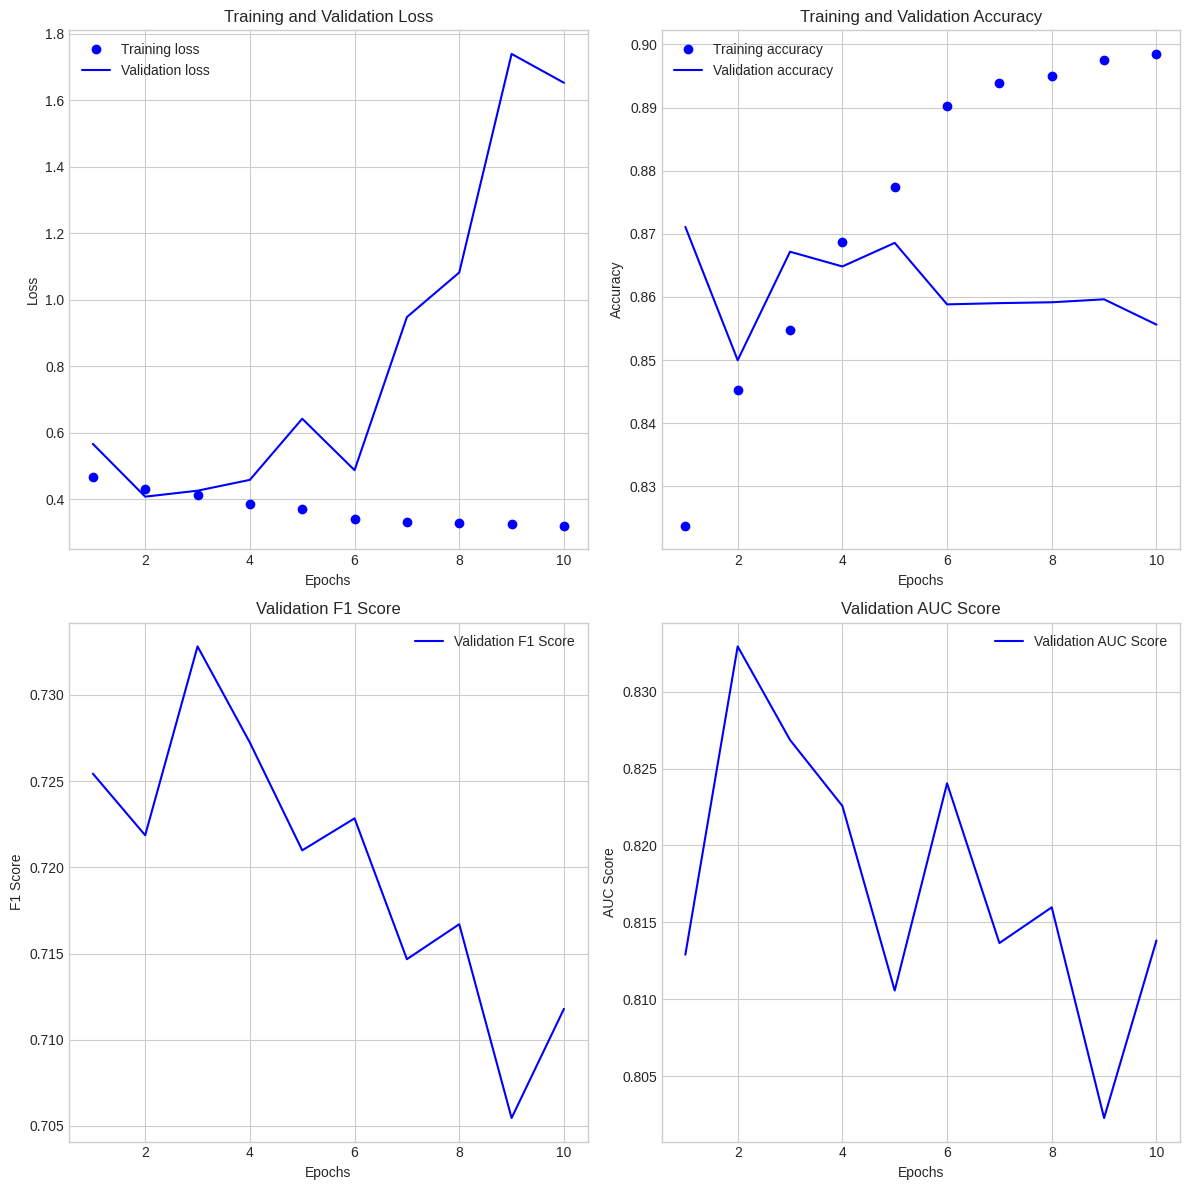

In [ ]:
import matplotlib.pyplot as plt

plt.style.use('seaborn-whitegrid')

# Generate x values (epochs)
epochs = range(1, len(train_loss_data) + 1)

# Create a new figure
plt.figure(figsize=(12, 12))

# Plot training loss and accuracy
plt.subplot(2, 2, 1)
plt.plot(epochs, train_loss_data, 'bo', label='Training loss')
plt.plot(epochs, val_loss_data, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(epochs, train_acc_data, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc_data, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot validation metrics
plt.subplot(2, 2, 3)
plt.plot(epochs, val_f1_data, 'b', label='Validation F1 Score')
plt.title('Validation F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(epochs, val_auc_data, 'b', label='Validation AUC Score')
plt.title('Validation AUC Score')
plt.xlabel('Epochs')
plt.ylabel('AUC Score')
plt.legend()

# Display the figure
plt.tight_layout()
plt.show()


# **TEST**

# **SBERT AND ViT MODEL**

In [ ]:
!pip install sentence_transformers timm tqdm

In [ ]:
import torch
import torchvision
import torch.nn as nn
from sentence_transformers import SentenceTransformer
import os
from PIL import Image
from tqdm import tqdm
from torch.utils.data import Dataset
import pandas as pd
import torchvision.models as models
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
import torch.nn.functional as F
import torch.optim as optim
import re
import timm
import cv2
import json
from sklearn.metrics import f1_score, roc_auc_score

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## **IMAGE TRANSFORM**

In [ ]:
image_transform = transforms.Compose([
    transforms.Resize(500),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.Lambda(lambda x: x.convert("RGB")),  # Convert grayscale to RGB
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the image
])



class ViTFeatureExtractor(nn.Module):
    def __init__(self, model_name='deit_base_patch16_224', pretrained=True):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained)
        self.model.head = nn.Identity()  # Remove the classification head

    def forward(self, x):
        return self.model(x)

vit_model = ViTFeatureExtractor().to(device)

## **TEXT TRANSFORM**

In [ ]:
def remove_url(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    no_url_text = url_pattern.sub(r'', text)
    return no_url_text

def load_dataset(file_path):
    # Load data
    with open(file_path, 'r') as f:
        data_dict = json.load(f)
    print(len(data_dict))
    # Process data and create examples
    data = {'id': [], 'text': [], 'label': []}
    for key, value in data_dict.items():
        # append the key to the 'id' list
        data['id'].append(key)
        text = remove_url(value['tweet_text'])
        label_list = [1 if num != 0 else 0 for num in value['labels']]
        label = max(set(label_list), key=label_list.count)
        data['text'].append(text)
        data['label'].append(label)

    # Create DataFrame
    df = pd.DataFrame(data)

    return df


def transform_text(sentence):
    sentence = sentence.lower()
    sentence = re.sub(r'@\w+', '@USER', sentence)
    return sentence


text_model = SentenceTransformer('all-MiniLM-L6-v2').to(device)

## **DATA LOADER**

In [ ]:
class FCM_Dataset(Dataset):
    def __init__(self, dataframe, img_dir, ocr_dir, text_transform=None, img_transform=None):
        """
        Args:
            dataframe (pandas.DataFrame): A pandas dataframe with columns ['id', 'text', 'label'].
            img_dir (str): Directory with all the images.
            ocr_dir (str): Directory with all the OCR text json files.
            text_transform (callable, optional): Optional transform to be applied on the text data.
            img_transform (callable, optional): Optional transform to be applied on the image data.
        """
        self.df = dataframe
        self.img_dir = img_dir
        self.ocr_dir = ocr_dir
        self.text_transform = text_transform
        self.img_transform = img_transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.img_dir, f"{self.df.iloc[idx, 0]}.jpg")
        img = Image.open(img_name)

        if self.img_transform:
            img = self.img_transform(img)

        ocr_file = os.path.join(self.ocr_dir, f"{self.df.iloc[idx, 0]}.json")
        if os.path.exists(ocr_file):
            with open(ocr_file, 'r') as f:
                ocr_data = json.load(f)
                ocr_text = ocr_data['img_text']
        else:
            ocr_text = ""

        text = self.df.iloc[idx, 1]

        if self.text_transform:
            text = self.text_transform(text)
            ocr_text = self.text_transform(ocr_text)

        label = self.df.iloc[idx, 2]

        return img, text, ocr_text, torch.tensor(label, dtype=torch.long)


In [ ]:
data = load_dataset('/content/MMHS150K_GT.json')

149823


In [ ]:
image_directory = '/content/img_resized'
ocr_text_directory = '/content/img_txt'

# Create dataset
fcm_dataset = FCM_Dataset(data, image_directory, ocr_text_directory, img_transform=image_transform,text_transform=transform_text)

# Get the lengths of splits
total_len = len(fcm_dataset)
print(total_len)
train_len = int(0.7 * total_len)
val_len = int(0.2 * total_len)
test_len = total_len - train_len - val_len  # Assign remaining data to test set

# Create random splits
train_data, val_data, test_data = random_split(fcm_dataset, lengths=[train_len, val_len, test_len])

# Create DataLoaders for each split
train_dataloader = DataLoader(train_data, batch_size=10, shuffle=True, num_workers=0)
val_dataloader = DataLoader(val_data, batch_size=10, shuffle=True, num_workers=0)
test_dataloader = DataLoader(test_data, batch_size=10, shuffle=True, num_workers=0)

149823


In [ ]:
for img, text, ocr, label in train_dataloader:
    print("Image shape: ", img.shape)
    print("Text: ",text)
    print("OCR: ",ocr)
    print("Label: ", label)
    break

Image shape:  torch.Size([10, 3, 224, 224])
Text:  ('@USER ric bucher? you already know it’s cap. nigga been wrong his whole career ', '😭😭 real nigga ', 'wait, so this nigga not born in jamaica? ', 'happy birthday to the biggest dyke of them all, mom loves u, u big bitch @USER ', '@USER  meg he said damn you trying to trap me hell nah nigga you can get up and leave  him ', '@USER @USER plz no run im ur retarded brother, honer phone user ', '@USER @USER i’m broke nigga!!! i’m broke ', 'when you thinking about how you gone get a scamming ass rich ass nigga ', '*when the argument already over*   her: soft ass nigga 😒🚶🏽\u200d♂️  me: ', 'finna invade czechoslovakia, netherlands, belgium, luxembourg and france wit my nigga italy ')
OCR:  ('', '', '', '', '', '', '', '', '', '100 * 96 *75 * 139 28 24 n그 a piains province in tuscany owner italy weather clear (24c) local time: l21:00 cllek to ew stale ')
Label:  tensor([0, 0, 0, 1, 0, 0, 0, 0, 0, 0])


## **MODEL SETUP**

In [ ]:
def encode_with_empty_check(text, model):
    if text.strip() == "":
        return torch.zeros(1, 384)
    return torch.tensor(model.encode([text]))

In [ ]:
class FCModel(nn.Module):
    def __init__(self, text_model, image_model):
        super().__init__()
        self.text_model = text_model
        self.image_model = image_model
        self.fc1 = nn.Linear(1536, 768)
        self.bn1 = nn.BatchNorm1d(768)  # BatchNorm after fc1
        self.fc2 = nn.Linear(768, 384)
        self.bn2 = nn.BatchNorm1d(384)  # BatchNorm after fc2
        self.out = nn.Linear(384, 2)

        # Initialize weights and bias
        nn.init.kaiming_normal_(self.fc1.weight)
        nn.init.constant_(self.fc1.bias, 0)

        nn.init.kaiming_normal_(self.fc2.weight)
        nn.init.constant_(self.fc2.bias, 0)

        nn.init.kaiming_normal_(self.out.weight)
        nn.init.constant_(self.out.bias, 0)

    def forward(self, img_in, text_in, ocr_text_in):
        img_in_vec = self.image_model(img_in)  # (B, 768)
        # print(img_in.shape)
        text_in_embeddings = torch.tensor(self.text_model.encode(list(text_in)))  # (B, 384)
        text_in_embeddings = text_in_embeddings.to(device)
        # print(text_in.shape)
        # ocr_text_in = torch.tensor(self.text_model.encode(list(ocr_text_in)))  # (B, 384)
        ocr_text_in = list(ocr_text_in)
        ocr_text_in_embeddings = torch.cat([encode_with_empty_check(text, text_model) for text in ocr_text_in], dim=0)
        ocr_text_in_embeddings = ocr_text_in_embeddings.to(device)
        # print(ocr_text_in_embeddings.shape)
        x = torch.cat((img_in_vec, ocr_text_in_embeddings, text_in_embeddings), dim=1)  # (B, 2348)
        # print(x.shape)

        x = F.relu(self.bn1(self.fc1(x)))  # Use ReLU after BatchNorm and fc1
        x = F.relu(self.bn2(self.fc2(x)))  # Use ReLU after BatchNorm and fc2
        x = self.out(x)
        # print(x.shape)
        return x

In [ ]:
model = FCModel(text_model, vit_model).to(device)

In [ ]:
class_weights = [1 / 75.327553, 1 / 24.672447]
class_weights = torch.tensor(class_weights)
class_weights = class_weights / class_weights.sum()
class_weights = class_weights.to(device)

In [ ]:
train_loss_data = []
train_acc_data = []
val_loss_data = []
val_acc_data = []
val_f1_data = []
val_auc_data = []

In [ ]:
# Define loss function
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# (Optional) Define learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [ ]:
def validate_model(model, dataloader, criterion):
    model.eval()
    running_loss = 0
    correct_predictions = 0
    all_preds = []
    all_labels = []

    val_loop = tqdm(enumerate(dataloader), total=len(dataloader), leave=True, position=0)

    with torch.no_grad():
        for i, (img, text, text_ocr, labels) in val_loop:
            img = img.to(device)
            # text = text.to(device)
            # text_ocr = text_ocr.to(device)
            labels = labels.to(device)
            outputs = model(img, text, text_ocr)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * img.size(0)
            _, preds = torch.max(outputs, 1)
            correct_predictions += (preds == labels.data).sum().item()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            val_loop.set_postfix({'validation_loss': '{:.3f}'.format(loss.item()/len(labels)),
                                  'validation_acc': '{:.3f}'.format(correct_predictions/(len(all_preds)))})

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = correct_predictions / len(dataloader.dataset)
    val_f1 = f1_score(all_labels, all_preds)
    val_auc = roc_auc_score(all_labels, all_preds)

    return epoch_loss, epoch_acc, val_f1, val_auc


def train_model(model, dataloader, optimizer, criterion):
    model.train()
    running_loss = 0
    correct_predictions = 0

    train_loop = tqdm(enumerate(dataloader), total=len(dataloader), leave=True, position=0)

    for i, (img, text, text_ocr, labels) in train_loop:
        img = img.to(device)
        # text = text.to(device)
        # text_ocr = text_ocr.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(img, text, text_ocr)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * img.size(0)
        _, preds = torch.max(outputs, 1)
        correct_predictions += (preds == labels.data).sum().item()

        train_loop.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(labels)),
                                'training_acc': '{:.3f}'.format(correct_predictions/((i+1)*len(labels)))})

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = correct_predictions / len(dataloader.dataset)

    return epoch_loss, epoch_acc


In [ ]:
EPOCHS = 10  # Set the number of epochs

# Variables for tracking best validation loss
best_val_loss = float('inf')
best_model = None

for epoch in range(EPOCHS):
    print(f'Starting epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    # Train the model
    train_loss, train_acc = train_model(model, train_dataloader, optimizer, criterion)
    train_loss_data.append(train_loss)
    train_acc_data.append(train_acc)
    print(f'\nTrain loss {train_loss}, accuracy {train_acc}')

    # Validate the model
    val_loss, val_acc, val_f1, val_auc = validate_model(model, val_dataloader, criterion)
    val_loss_data.append( val_loss)
    val_acc_data.append(val_acc)
    val_f1_data.append(val_f1)
    val_auc_data.append(val_auc)
    print(f'\nValidation loss {val_loss}, accuracy {val_acc}, F1 {val_f1}, AUC {val_auc}')

    # Check if this model is the best so far
    if val_loss < best_val_loss:
        print(f'New best model found (validation loss decreased from {best_val_loss} to {val_loss})')
        best_val_loss = val_loss
        best_model = model.state_dict()  # Save the model parameters

    scheduler.step()

print('Training complete.')

Starting epoch 1/10
----------


100%|██████████| 10488/10488 [1:15:20<00:00,  2.32it/s, training_loss=0.044, training_acc=1.098]



Train loss 0.6681237667298862, accuracy 0.65912124794996


100%|██████████| 2997/2997 [09:05<00:00,  5.50it/s, validation_loss=0.282, validation_acc=0.701]



Validation loss 0.6488787900174576, accuracy 0.7005406487785343, F1 0.41933605125218404, AUC 0.6130896287378044
New best model found (validation loss decreased from inf to 0.6488787900174576)
Starting epoch 2/10
----------


100%|██████████| 10488/10488 [1:14:16<00:00,  2.35it/s, training_loss=0.169, training_acc=1.160]



Train loss 0.6297739285838868, accuracy 0.6959361531713643


100%|██████████| 2997/2997 [09:00<00:00,  5.55it/s, validation_loss=0.166, validation_acc=0.725]



Validation loss 0.6115447965368157, accuracy 0.7247363502870111, F1 0.5051595872330215, AUC 0.6738068121634224
New best model found (validation loss decreased from 0.6488787900174576 to 0.6115447965368157)
Starting epoch 3/10
----------


100%|██████████| 10488/10488 [1:14:02<00:00,  2.36it/s, training_loss=0.110, training_acc=1.177]



Train loss 0.6182947031574758, accuracy 0.7062435638277585


100%|██████████| 2997/2997 [08:55<00:00,  5.60it/s, validation_loss=0.187, validation_acc=0.722]



Validation loss 0.6156469938783998, accuracy 0.7215325056734748, F1 0.4994000479961602, AUC 0.6694738432769318
Starting epoch 4/10
----------


100%|██████████| 10488/10488 [1:13:49<00:00,  2.37it/s, training_loss=0.072, training_acc=1.185]



Train loss 0.6100728220990718, accuracy 0.7112590106411381


100%|██████████| 2997/2997 [08:44<00:00,  5.71it/s, validation_loss=0.273, validation_acc=0.709]



Validation loss 0.6100494252865185, accuracy 0.7089841142704579, F1 0.5108268820823517, AUC 0.6791839796992706
New best model found (validation loss decreased from 0.6115447965368157 to 0.6100494252865185)
Starting epoch 5/10
----------


100%|██████████| 10488/10488 [1:13:18<00:00,  2.38it/s, training_loss=0.093, training_acc=1.199]



Train loss 0.6006051595679951, accuracy 0.7192684694305657


100%|██████████| 2997/2997 [08:55<00:00,  5.60it/s, validation_loss=0.082, validation_acc=0.720]



Validation loss 0.6142346694629862, accuracy 0.7199973301294887, F1 0.5048979110114481, AUC 0.6738028957557106
Starting epoch 6/10
----------


100%|██████████| 10488/10488 [1:14:26<00:00,  2.35it/s, training_loss=0.097, training_acc=1.224]



Train loss 0.5780995358484252, accuracy 0.7346771425302262


100%|██████████| 2997/2997 [09:01<00:00,  5.54it/s, validation_loss=0.147, validation_acc=0.735]



Validation loss 0.6183666254578628, accuracy 0.7346148711787478, F1 0.49918125708527517, AUC 0.6689647825773121
Starting epoch 7/10
----------


100%|██████████| 10488/10488 [1:14:23<00:00,  2.35it/s, training_loss=0.093, training_acc=1.233]



Train loss 0.5693701653987779, accuracy 0.7400739921431023


100%|██████████| 2997/2997 [09:04<00:00,  5.50it/s, validation_loss=0.069, validation_acc=0.711]



Validation loss 0.6222288320125733, accuracy 0.710652783340008, F1 0.5008060801473976, AUC 0.6708881725812658
Starting epoch 8/10
----------


100%|██████████| 10488/10488 [1:14:27<00:00,  2.35it/s, training_loss=0.140, training_acc=1.241]



Train loss 0.562678503194903, accuracy 0.7447175712269728


100%|██████████| 2997/2997 [09:02<00:00,  5.52it/s, validation_loss=0.183, validation_acc=0.715]



Validation loss 0.6224898342463382, accuracy 0.7145908423441463, F1 0.4969411764705883, AUC 0.6677351992626067
Starting epoch 9/10
----------


  9%|▉         | 967/10488 [06:51<1:07:36,  2.35it/s, training_loss=0.051, training_acc=0.746]


KeyboardInterrupt: ignored

In [ ]:
best_model

In [ ]:
val_auc_data

[0.6130896287378044,
 0.6738068121634224,
 0.6694738432769318,
 0.6791839796992706,
 0.6738028957557106,
 0.6689647825773121,
 0.6708881725812658,
 0.6677351992626067]

In [ ]:
train_loss_data

[0.6681237667298862,
 0.6297739285838868,
 0.6182947031574758,
 0.6100728220990718,
 0.6006051595679951,
 0.5780995358484252,
 0.5693701653987779,
 0.562678503194903]

In [ ]:
train_acc_data

[0.65912124794996,
 0.6959361531713643,
 0.7062435638277585,
 0.7112590106411381,
 0.7192684694305657,
 0.7346771425302262,
 0.7400739921431023,
 0.7447175712269728]

In [ ]:
val_loss_data

[0.6488787900174576,
 0.6115447965368157,
 0.6156469938783998,
 0.6100494252865185,
 0.6142346694629862,
 0.6183666254578628,
 0.6222288320125733,
 0.6224898342463382]

In [ ]:
val_acc_data

[0.7005406487785343,
 0.7247363502870111,
 0.7215325056734748,
 0.7089841142704579,
 0.7199973301294887,
 0.7346148711787478,
 0.710652783340008,
 0.7145908423441463]

In [ ]:
val_f1_data

[0.41933605125218404,
 0.5051595872330215,
 0.4994000479961602,
 0.5108268820823517,
 0.5048979110114481,
 0.49918125708527517,
 0.5008060801473976,
 0.4969411764705883]

In [ ]:
test_loss, test_acc, test_f1, test_auc = validate_model(model, test_dataloader, criterion)

100%|██████████| 1499/1499 [04:50<00:00,  5.17it/s, validation_loss=0.085, validation_acc=0.723]


In [ ]:
test_loss

0.6250007812990204

In [ ]:
test_acc

0.7231529066275112

In [ ]:
test_f1

0.49782082324455196

In [ ]:
test_loss, test_acc, test_f1, test_auc = validate_model(best_model, test_dataloader, criterion)

AttributeError: ignored

In [ ]:
torch.save(model, '/content/drive/MyDrive/hate_text_data/model_final_tf.pth')

In [ ]:
torch.save(best_model, '/content/drive/MyDrive/hate_text_data/best_model_tf.pth')

<ipython-input-34-4199a861a503>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


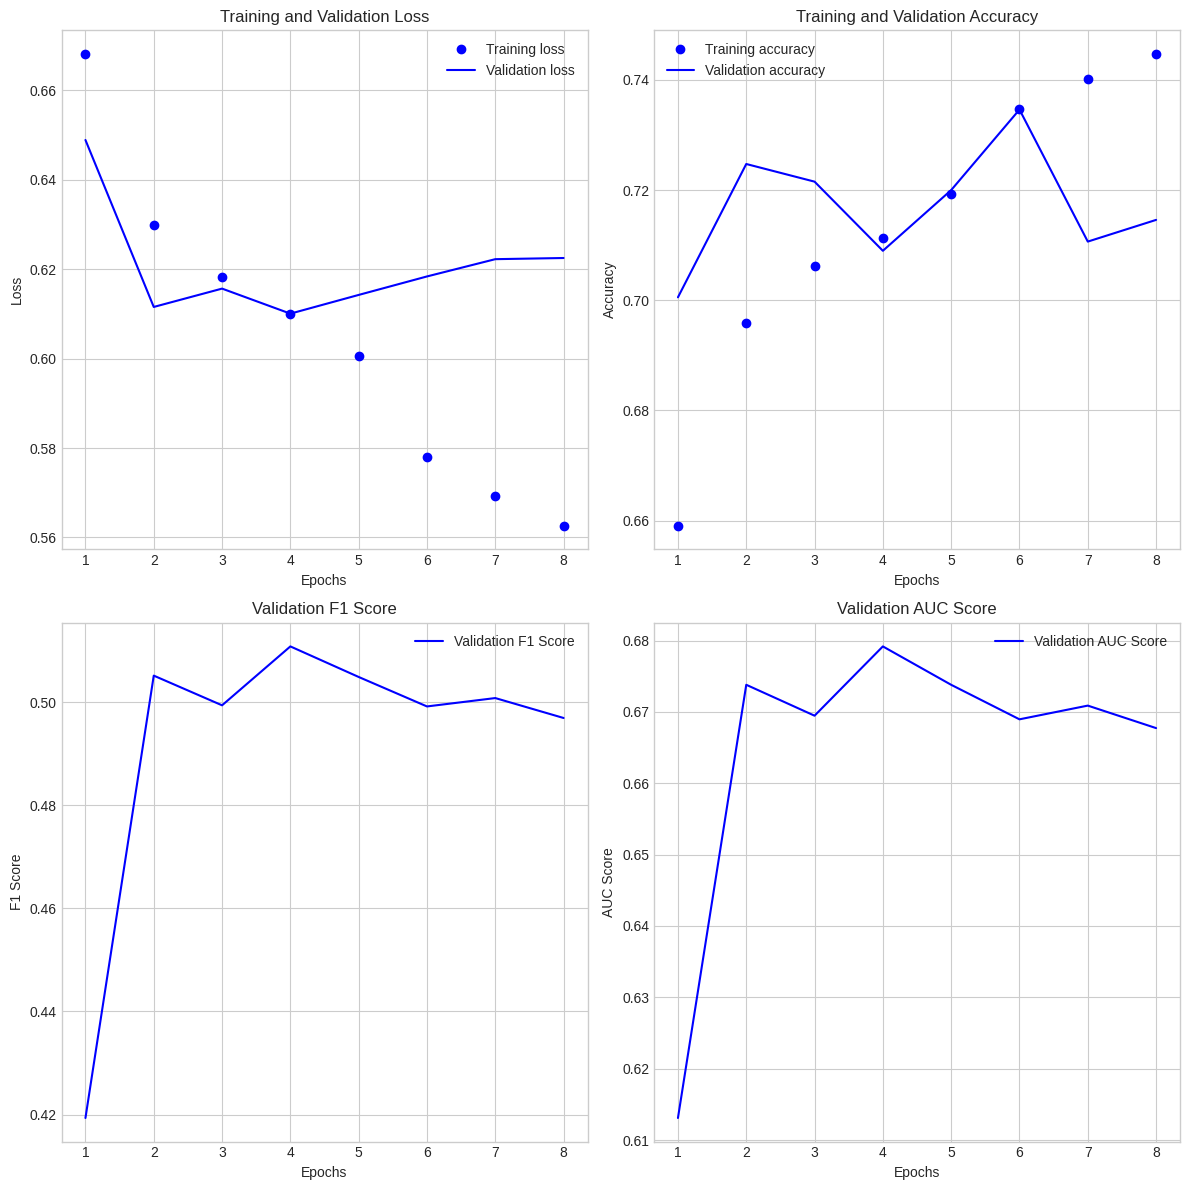

In [ ]:
import matplotlib.pyplot as plt

plt.style.use('seaborn-whitegrid')

# Generate x values (epochs)
epochs = range(1, len(train_loss_data) + 1)

# Create a new figure
plt.figure(figsize=(12, 12))

# Plot training loss and accuracy
plt.subplot(2, 2, 1)
plt.plot(epochs, train_loss_data, 'bo', label='Training loss')
plt.plot(epochs, val_loss_data, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(epochs, train_acc_data, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc_data, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot validation metrics
plt.subplot(2, 2, 3)
plt.plot(epochs, val_f1_data, 'b', label='Validation F1 Score')
plt.title('Validation F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(epochs, val_auc_data, 'b', label='Validation AUC Score')
plt.title('Validation AUC Score')
plt.xlabel('Epochs')
plt.ylabel('AUC Score')
plt.legend()

# Display the figure
plt.tight_layout()
plt.show()


# **MultiModal InfoMax**

In [ ]:
image_transform = transforms.Compose([
    transforms.Resize(500),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.Lambda(lambda x: x.convert("RGB")),  # Convert grayscale to RGB
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the image
])


In [ ]:
pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 29.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 65.1 MB/s eta 0:00:00


In [ ]:
import timm

class ViTFeatureExtractor(nn.Module):
    def __init__(self, model_name='deit_base_patch16_224', pretrained=True):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained)
        self.model.head = nn.Identity()  # Remove the classification head

    def forward(self, x):
        return self.model(x)

vit_model = ViTFeatureExtractor().to(device)

In [ ]:
import torch
import torch.nn.functional as F
import time

from torch import nn
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

class SubNet(nn.Module):
    '''
    The subnetwork that is used in TFN for video and audio in the pre-fusion stage
    '''

    def __init__(self, in_size, hidden_size, n_class, dropout, modal_name='text'):
        '''
        Args:
            in_size: input dimension
            hidden_size: hidden layer dimension
            dropout: dropout probability
        Output:
            (return value in forward) a tensor of shape (batch_size, hidden_size)
        '''
        super(SubNet, self).__init__()
        # self.norm = nn.BatchNorm1d(in_size)
        self.drop = nn.Dropout(p=dropout)
        self.linear_1 = nn.Linear(in_size, hidden_size)
        self.linear_2 = nn.Linear(hidden_size, hidden_size)
        self.linear_3 = nn.Linear(hidden_size, n_class)

    def forward(self, x):
        '''
        Args:
            x: tensor of shape (batch_size, in_size)
        '''
        # normed = self.norm(x)
        dropped = self.drop(x)
        y_1 = torch.tanh(self.linear_1(dropped))
        fusion = self.linear_2(y_1)
        y_2 = torch.tanh(self.linear_2(y_1))
        y_3 = self.linear_3(y_2)
        return y_2, y_3

class MMILB(nn.Module):
    """Compute the Modality Mutual Information Lower Bound (MMILB) given bimodal representations.
    Args:
        x_size (int): embedding size of input modality representation x
        y_size (int): embedding size of input modality representation y
        mid_activation(int): the activation function in the middle layer of MLP
        last_activation(int): the activation function in the last layer of MLP that outputs logvar
    """
    def __init__(self, x_size, y_size, mid_activation='ReLU', last_activation='Tanh'):
        super(MMILB, self).__init__()
        try:
            self.mid_activation = getattr(nn, mid_activation)
            self.last_activation = getattr(nn, last_activation)
        except:
            raise ValueError("Error: CLUB activation function not found in torch library")
        self.mlp_mu = nn.Sequential(
            nn.Linear(x_size, y_size),
            self.mid_activation(),
            nn.Linear(y_size, y_size)
        )
        self.mlp_logvar = nn.Sequential(
            nn.Linear(x_size, y_size),
            self.mid_activation(),
            nn.Linear(y_size, y_size),
        )
        self.entropy_prj = nn.Sequential(
            nn.Linear(y_size, y_size // 4),
            nn.Tanh()
        )

    def forward(self, x, y, labels=None, mem=None):
        """ Forward lld (gaussian prior) and entropy estimation, partially refers the implementation
        of https://github.com/Linear95/CLUB/blob/master/MI_DA/MNISTModel_DANN.py
            Args:
                x (Tensor): x in above equation, shape (bs, x_size)
                y (Tensor): y in above equation, shape (bs, y_size)
        """
        mu, logvar = self.mlp_mu(x), self.mlp_logvar(x) # (bs, hidden_size)
        batch_size = mu.size(0)

        positive = -(mu - y)**2/2./torch.exp(logvar)
        lld = torch.mean(torch.sum(positive,-1))

        # For Gaussian Distribution Estimation
        pos_y = neg_y = None
        H = 0.0
        sample_dict = {'pos':None, 'neg':None}

        if labels is not None:
            # store pos and neg samples
            y = self.entropy_prj(y)
            pos_y = y[labels.squeeze() > 0]
            neg_y = y[labels.squeeze() < 0]

            sample_dict['pos'] = pos_y
            sample_dict['neg'] = neg_y

            # estimate entropy
            if mem is not None and mem.get('pos', None) is not None:
                pos_history = mem['pos']
                neg_history = mem['neg']

                # Diagonal setting
                # pos_all = torch.cat(pos_history + [pos_y], dim=0) # n_pos, emb
                # neg_all = torch.cat(neg_history + [neg_y], dim=0)
                # mu_pos = pos_all.mean(dim=0)
                # mu_neg = neg_all.mean(dim=0)

                # sigma_pos = torch.mean(pos_all ** 2, dim = 0) - mu_pos ** 2 # (embed)
                # sigma_neg = torch.mean(neg_all ** 2, dim = 0) - mu_neg ** 2 # (embed)
                # H = 0.25 * (torch.sum(torch.log(sigma_pos)) + torch.sum(torch.log(sigma_neg)))

                # compute the entire co-variance matrix
                pos_all = torch.cat(pos_history + [pos_y], dim=0) # n_pos, emb
                neg_all = torch.cat(neg_history + [neg_y], dim=0)
                mu_pos = pos_all.mean(dim=0)
                mu_neg = neg_all.mean(dim=0)
                sigma_pos = torch.mean(torch.bmm((pos_all-mu_pos).unsqueeze(-1), (pos_all-mu_pos).unsqueeze(1)), dim=0)
                sigma_neg = torch.mean(torch.bmm((neg_all-mu_neg).unsqueeze(-1), (neg_all-mu_neg).unsqueeze(1)), dim=0)
                a = 17.0795
                H = 0.25 * (torch.logdet(sigma_pos) + torch.logdet(sigma_neg))

        return lld, sample_dict, H

class CPC(nn.Module):
    """
        Contrastive Predictive Coding: score computation. See https://arxiv.org/pdf/1807.03748.pdf.

        Args:
            x_size (int): embedding size of input modality representation x
            y_size (int): embedding size of input modality representation y
    """
    def __init__(self, x_size, y_size, n_layers=1, activation='Tanh'):
        super().__init__()
        self.x_size = x_size
        self.y_size = y_size
        self.layers = n_layers
        self.activation = getattr(nn, activation)
        if n_layers == 1:
            self.net = nn.Linear(
                in_features=y_size,
                out_features=x_size
            )
        else:
            net = []
            for i in range(n_layers):
                if i == 0:
                    net.append(nn.Linear(self.y_size, self.x_size))
                    net.append(self.activation())
                else:
                    net.append(nn.Linear(self.x_size, self.x_size))
            self.net = nn.Sequential(*net)

    def forward(self, x, y):
        """Calulate the score
        """
        # import ipdb;ipdb.set_trace()
        x_pred = self.net(y)    # bs, emb_size

        # normalize to unit sphere
        x_pred = x_pred / x_pred.norm(dim=1, keepdim=True)
        x = x / x.norm(dim=1, keepdim=True)

        pos = torch.sum(x*x_pred, dim=-1)   # bs
        neg = torch.logsumexp(torch.matmul(x, x_pred.t()), dim=-1)   # bs
        nce = -(pos - neg).mean()
        return nce

In [ ]:
class MMIM(nn.Module):
    def __init__(self, text_model, image_model):
        super().__init__()
        self.text_model = text_model
        self.image_model = image_model
        self.text_proj = nn.Linear(300, 512)
        self.img_proj = nn.Linear(768, 512)
        self.mi_ti = MMILB(x_size=512, y_size=512)
        self.cpc_text = CPC(x_size=512, y_size=512)
        self.cpc_img = CPC(x_size=512, y_size=512)

        self.fusion_prj = SubNet(
            in_size = 1068,
            hidden_size = 512,
            n_class = 2,
            dropout = 0.2
        )

        # # Initialize weights and bias
        # nn.init.kaiming_normal_(self.fc1.weight)
        # nn.init.constant_(self.fc1.bias, 0)

        # nn.init.kaiming_normal_(self.fc2.weight)
        # nn.init.constant_(self.fc2.bias, 0)

        # nn.init.kaiming_normal_(self.out.weight)
        # nn.init.constant_(self.out.bias, 0)

    def forward(self, img_in, text_in, ocr_text_in):
        img_in = self.image_model(img_in)  # (B, 768)
        text_in = self.text_model(text_in)  # (B, 150)
        ocr_text_in = self.text_model(ocr_text_in)  # (B, 150)
        all_text_in = torch.cat((ocr_text_in, text_in), dim=1)

        text_proj = self.text_proj(all_text_in)
        img_proj = self.img_proj(img_in)

        lld_ti, ti_pn, H_ti = self.mi_ti(x=text_proj, y=img_proj)

        fusion, preds = self.fusion_prj(torch.cat([img_in, ocr_text_in, text_in], dim=1))

        nce_text = self.cpc_text(text_proj, fusion)
        nce_img = self.cpc_img(img_proj, fusion)

        nce = nce_text + nce_img


        return preds, lld_ti, nce, {'ti':ti_pn}, H_ti

In [ ]:
model = MMIM(textFeatureExtractorModel, vit_model).to(device)

In [ ]:
img = img.to(device)
txt = text.to(device)
ocr = ocr.to(device)

In [ ]:
res1, res2, res3, res4, res5 = model(img, txt, ocr)

In [ ]:
res1

In [ ]:
res2

tensor(-76.5017, device='cuda:0', grad_fn=<MeanBackward0>)

In [ ]:
res3.item()

4.605652809143066

In [ ]:
class_weights = [1 / 75.327553, 1 / 24.672447]
class_weights = torch.tensor(class_weights)
class_weights = class_weights / class_weights.sum()
class_weights = class_weights.to(device)


In [ ]:
# Define loss function
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# (Optional) Define learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [ ]:
train_loss_data = []
train_acc_data = []
val_loss_data = []
val_acc_data = []
val_f1_data = []
val_auc_data = []
val_recall_data = []
val_precision_data =[]
lld_ti = []
nce = []

In [ ]:
from sklearn.metrics import precision_score, recall_score

In [ ]:
def validate_model(model, dataloader, criterion):
    model.eval()
    running_loss = 0
    correct_predictions = 0
    all_preds = []
    all_labels = []

    val_loop = tqdm(enumerate(dataloader), total=len(dataloader), leave=True, position=0)

    with torch.no_grad():
        for i, (img, text, text_ocr, labels) in val_loop:
            img = img.to(device)
            text = text.to(device)
            text_ocr = text_ocr.to(device)
            labels = labels.to(device)
            outputs, lld , nce , _ , _ = model(img, text, text_ocr)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * img.size(0)
            _, preds = torch.max(outputs, 1)
            correct_predictions += (preds == labels.data).sum().item()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            val_loop.set_postfix({'validation_loss': '{:.3f}'.format(loss.item()/len(labels)),
                                  'validation_acc': '{:.3f}'.format(correct_predictions/(len(all_preds)))})

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = correct_predictions / len(dataloader.dataset)
    val_f1 = f1_score(all_labels, all_preds)
    val_auc = roc_auc_score(all_labels, all_preds)
    val_precision = precision_score(all_labels, all_preds)
    val_recall = recall_score(all_labels, all_preds)

    return epoch_loss, epoch_acc, val_f1, val_auc, val_precision, val_recall


def train_model(model, dataloader, optimizer, criterion):
    model.train()
    running_loss = 0
    correct_predictions = 0
    lld_loss = 0
    nce_loss = 0

    train_loop = tqdm(enumerate(dataloader), total=len(dataloader), leave=True, position=0)

    for i, (img, text, text_ocr, labels) in train_loop:
        img = img.to(device)
        text = text.to(device)
        text_ocr = text_ocr.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs, lld , nce , _ , _   = model(img, text, text_ocr)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        lld_loss += lld.item() * img.size(0)
        nce_loss += nce.item() * img.size(0)
        running_loss += loss.item() * img.size(0)

        _, preds = torch.max(outputs, 1)
        correct_predictions += (preds == labels.data).sum().item()

        train_loop.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(labels)),
                                'training_acc': '{:.3f}'.format(correct_predictions/((i+1)*len(labels)))})

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = correct_predictions / len(dataloader.dataset)
    epoch_lld = lld_loss / len(dataloader.dataset)
    epoch_nce = nce_loss / len(dataloader.dataset)

    return epoch_loss, epoch_acc,  epoch_nce,  epoch_lld


In [ ]:
EPOCHS = 10  # Set the number of epochs

# Variables for tracking best validation loss
best_val_loss = float('inf')
best_model = None

for epoch in range(EPOCHS):
    print(f'Starting epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    # Train the model
    train_loss, train_acc, lld_loss, nce_loss = train_model(model, train_dataloader, optimizer, criterion)
    train_loss_data.append(train_loss)
    train_acc_data.append(train_acc)
    lld_ti.append(lld_loss)
    nce.append(nce_loss)

    print(f'\nTrain loss {train_loss}, accuracy {train_acc}, nce {nce_loss}, lld {lld_loss}')

    # Validate the model
    val_loss, val_acc, val_f1, val_auc, val_prec, val_recl = validate_model(model, val_dataloader, criterion)
    val_loss_data.append( val_loss)
    val_acc_data.append(val_acc)
    val_f1_data.append(val_f1)
    val_auc_data.append(val_auc)
    val_precision_data.append(val_prec)
    val_recall_data.append(val_recl)
    print(f'\nValidation loss {val_loss}, accuracy {val_acc}, F1 {val_f1}, AUC {val_auc}')

    # Check if this model is the best so far
    if val_loss < best_val_loss:
        print(f'New best model found (validation loss decreased from {best_val_loss} to {val_loss})')
        best_val_loss = val_loss
        best_model = model.state_dict()  # Save the model parameters

    scheduler.step()

print('Training complete.')

Starting epoch 1/10
----------


100%|██████████| 10488/10488 [1:12:37<00:00,  2.41it/s, training_loss=0.041, training_acc=1.427]



Train loss 0.4181388905423562, accuracy 0.8562016095198138, nce -26.695388824262547, lld 4.595673774189787


100%|██████████| 2997/2997 [07:27<00:00,  6.70it/s, validation_loss=0.033, validation_acc=0.864]



Validation loss 0.39558588961387225, accuracy 0.8640368442130557, F1 0.7438702376461712, AUC 0.8399689984263541
New best model found (validation loss decreased from inf to 0.39558588961387225)
Starting epoch 2/10
----------


100%|██████████| 10488/10488 [1:11:55<00:00,  2.43it/s, training_loss=0.075, training_acc=1.455]



Train loss 0.3837020723143142, accuracy 0.8727640260879514, nce -25.730542702880193, lld 4.590825929049383


100%|██████████| 2997/2997 [07:20<00:00,  6.81it/s, validation_loss=0.137, validation_acc=0.866]



Validation loss 0.3976545045245551, accuracy 0.8660726204779068, F1 0.7422442032243561, AUC 0.835155452431224
Starting epoch 3/10
----------


100%|██████████| 10488/10488 [1:11:44<00:00,  2.44it/s, training_loss=0.049, training_acc=1.468]



Train loss 0.364597377460489, accuracy 0.8807067393874671, nce -26.024969666613163, lld 4.588520524353488


100%|██████████| 2997/2997 [07:18<00:00,  6.83it/s, validation_loss=0.092, validation_acc=0.862]



Validation loss 0.39784028243729525, accuracy 0.8619343211854225, F1 0.741421338833677, AUC 0.8392392188117634
Starting epoch 4/10
----------


100%|██████████| 10488/10488 [1:11:43<00:00,  2.44it/s, training_loss=0.042, training_acc=1.486]



Train loss 0.3464014839621527, accuracy 0.8913478774934208, nce -27.027763261143598, lld 4.587002014294519


100%|██████████| 2997/2997 [07:18<00:00,  6.83it/s, validation_loss=0.012, validation_acc=0.873]



Validation loss 0.40258926486176494, accuracy 0.8729475370444534, F1 0.7484305821714136, AUC 0.8345932320015369
Starting epoch 5/10
----------


100%|██████████| 10488/10488 [1:11:42<00:00,  2.44it/s, training_loss=0.015, training_acc=1.494]



Train loss 0.3358607874062398, accuracy 0.8967065868263473, nce -28.62919323795097, lld 4.585260100839176


100%|██████████| 2997/2997 [07:19<00:00,  6.82it/s, validation_loss=0.035, validation_acc=0.871]



Validation loss 0.4051427231359834, accuracy 0.8713456147376852, F1 0.7441428286984801, AUC 0.8309780243049196
Starting epoch 6/10
----------


100%|██████████| 10488/10488 [1:11:43<00:00,  2.44it/s, training_loss=0.015, training_acc=1.504]



Train loss 0.3225969910771399, accuracy 0.9021701819291353, nce -28.360555316132544, lld 4.595241895924672


100%|██████████| 2997/2997 [07:17<00:00,  6.85it/s, validation_loss=0.044, validation_acc=0.867]



Validation loss 0.40613674036730807, accuracy 0.8674075557335469, F1 0.7425646342253612, AUC 0.8338986782017374
Starting epoch 7/10
----------


100%|██████████| 10488/10488 [1:11:41<00:00,  2.44it/s, training_loss=0.012, training_acc=1.506]



Train loss 0.3196904700061315, accuracy 0.9033429955375872, nce -28.014287883445444, lld 4.591139587695295


100%|██████████| 2997/2997 [07:19<00:00,  6.82it/s, validation_loss=0.026, validation_acc=0.866]



Validation loss 0.4043263726524721, accuracy 0.8662728607662529, F1 0.7421326983718386, AUC 0.834752346274937
Starting epoch 8/10
----------


100%|██████████| 10488/10488 [1:11:40<00:00,  2.44it/s, training_loss=0.014, training_acc=1.508]



Train loss 0.3154334669002146, accuracy 0.9050402379953469, nce -28.085864440214216, lld 4.590799662681215


100%|██████████| 2997/2997 [07:20<00:00,  6.81it/s, validation_loss=0.290, validation_acc=0.867]



Validation loss 0.40631393033465585, accuracy 0.8672406888265919, F1 0.7423575129533677, AUC 0.8338322437076482
Starting epoch 9/10
----------


  3%|▎         | 357/10488 [02:26<1:09:28,  2.43it/s, training_loss=0.065, training_acc=0.913]


KeyboardInterrupt: ignored

In [ ]:
torch.save(model, '/content/drive/MyDrive/hate_text_data/model_mimm_tf.pth')

<ipython-input-60-37f91ad63259>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


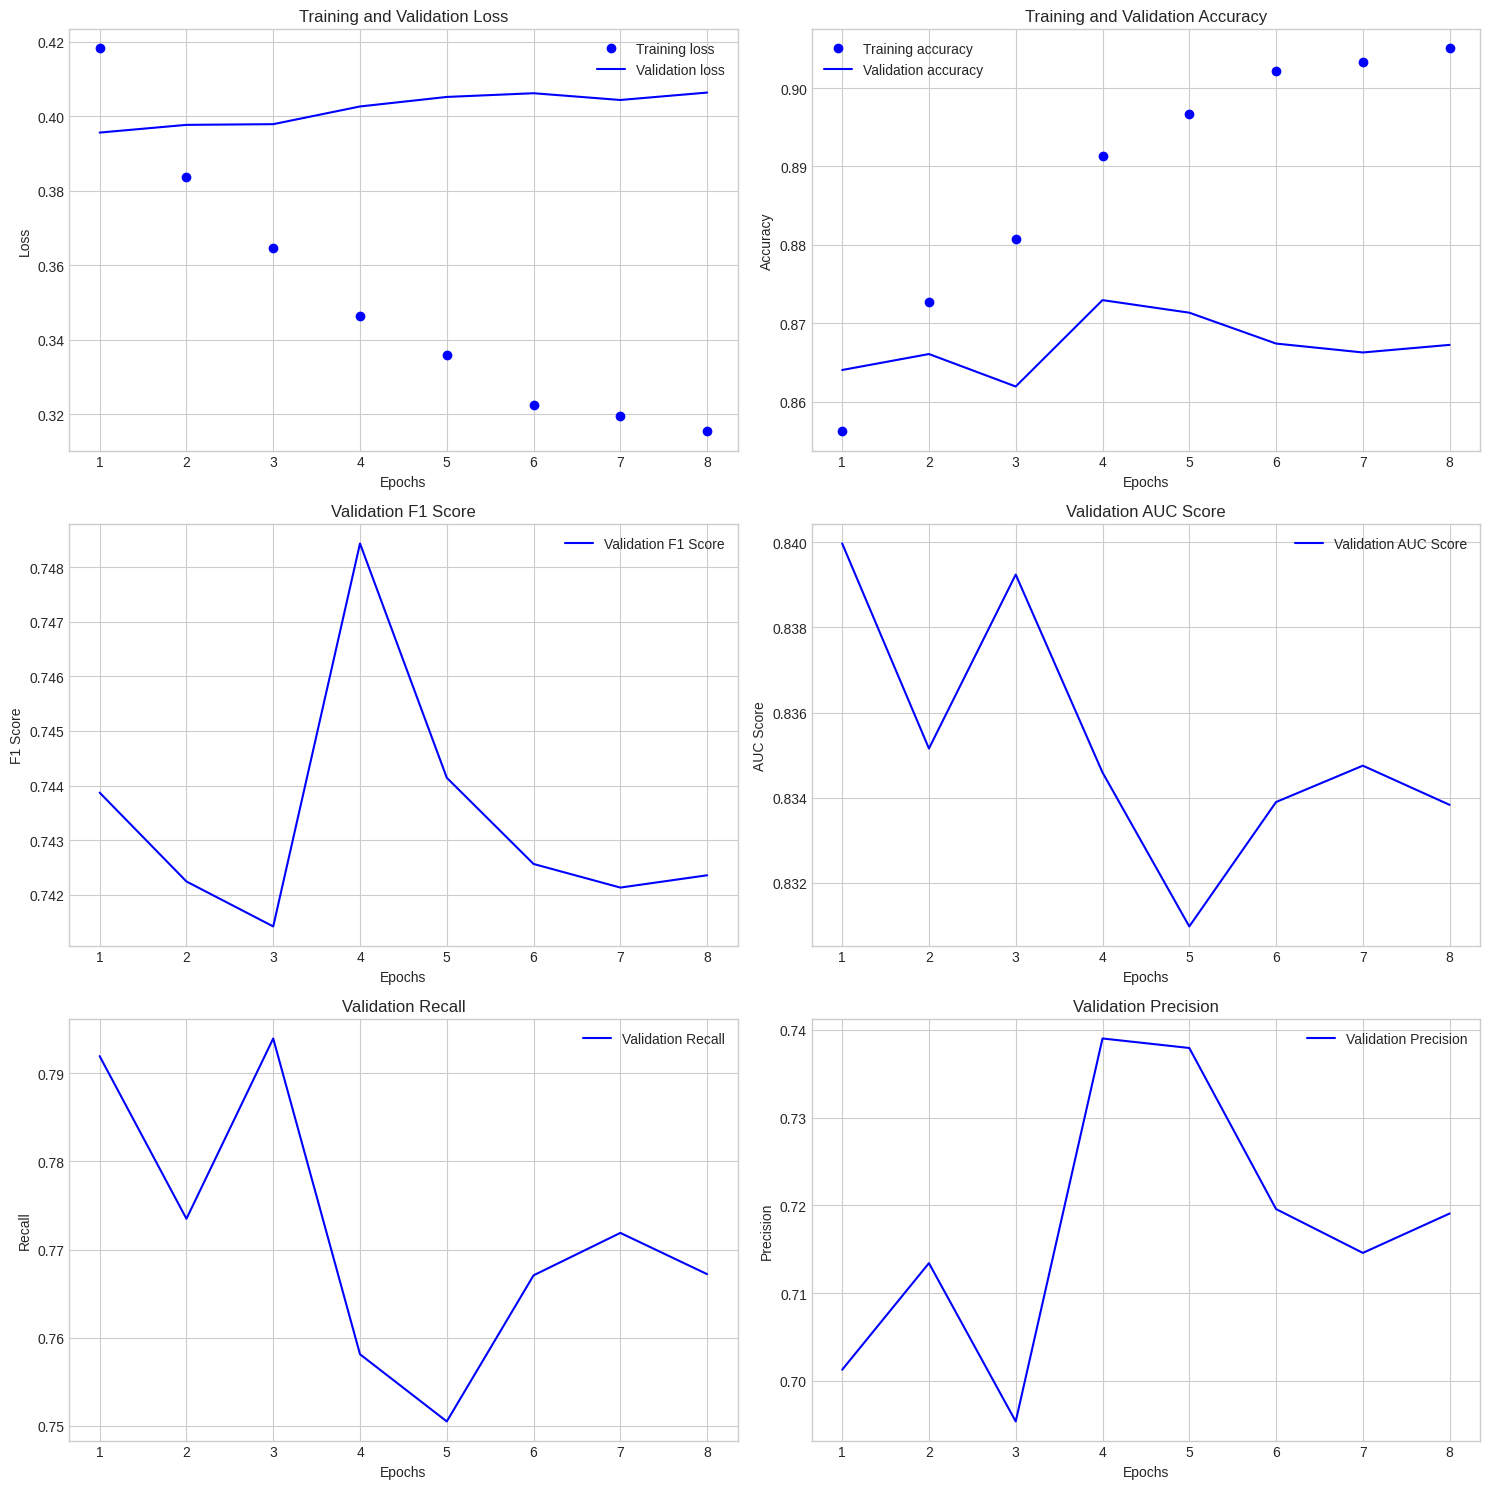

In [ ]:
import matplotlib.pyplot as plt

plt.style.use('seaborn-whitegrid')

# Generate x values (epochs)
epochs = range(1, len(train_loss_data) + 1)

# Create a new figure
plt.figure(figsize=(15, 15))

# Plot training loss and accuracy
plt.subplot(3, 2, 1)
plt.plot(epochs, train_loss_data, 'bo', label='Training loss')
plt.plot(epochs, val_loss_data, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(3, 2, 2)
plt.plot(epochs, train_acc_data, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc_data, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot validation F1 score
plt.subplot(3, 2, 3)
plt.plot(epochs, val_f1_data, 'b', label='Validation F1 Score')
plt.title('Validation F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()

# Plot validation AUC score
plt.subplot(3, 2, 4)
plt.plot(epochs, val_auc_data, 'b', label='Validation AUC Score')
plt.title('Validation AUC Score')
plt.xlabel('Epochs')
plt.ylabel('AUC Score')
plt.legend()

# Plot validation recall
plt.subplot(3, 2, 5)
plt.plot(epochs, val_recall_data, 'b', label='Validation Recall')
plt.title('Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

# Plot validation precision
plt.subplot(3, 2, 6)
plt.plot(epochs, val_precision_data, 'b', label='Validation Precision')
plt.title('Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

# Display the figure
plt.tight_layout()
plt.show()


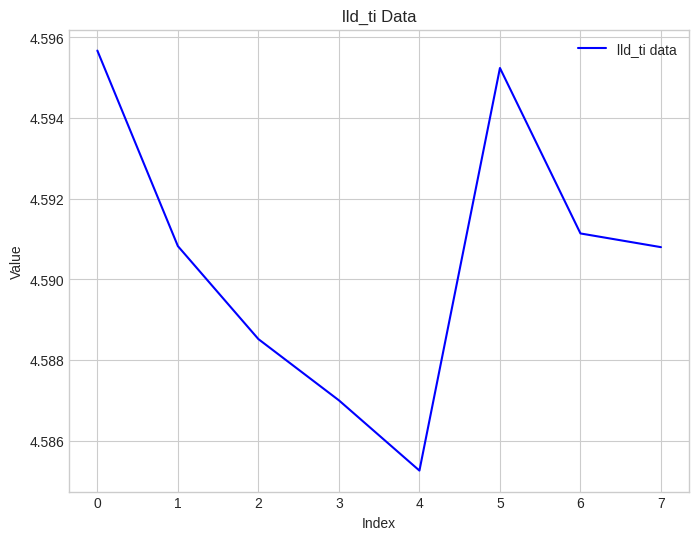

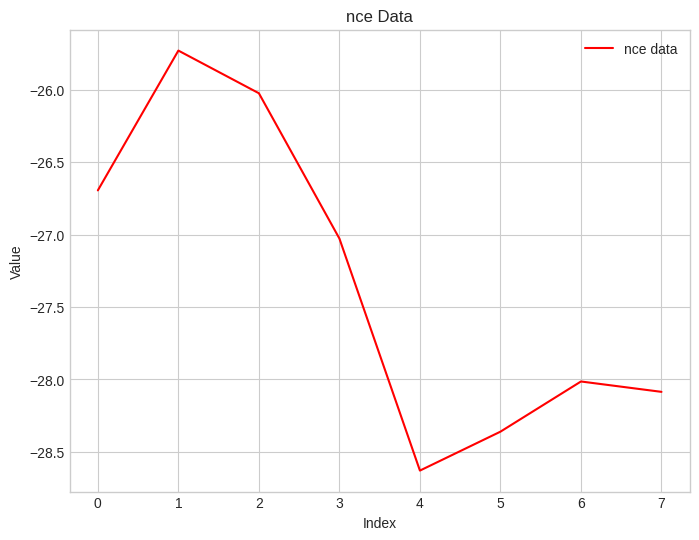

In [ ]:
import matplotlib.pyplot as plt

# Plotting lld_ti list
plt.figure(figsize=(8, 6))
plt.plot(lld_ti, label='lld_ti data', color='blue')
plt.title('lld_ti Data')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.show()

# Plotting nce list
plt.figure(figsize=(8, 6))
plt.plot(nce, label='nce data', color='red')
plt.title('nce Data')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.show()


In [ ]:
test_loss, test_acc, test_f1, test_auc, val_precision, val_recall = validate_model(model, test_dataloader, criterion)

100%|██████████| 1499/1499 [03:42<00:00,  6.73it/s, validation_loss=0.369, validation_acc=0.861]


In [ ]:
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")
print(f"Test AUC Score: {test_auc:.4f}")
print(f"Validation Precision: {val_precision:.4f}")
print(f"Validation Recall: {val_recall:.4f}")


Test Loss: 0.4321
Test Accuracy: 0.8605
Test F1 Score: 0.7309
Test AUC Score: 0.8257
Validation Precision: 0.7074
Validation Recall: 0.7560


In [ ]:
print("Train Loss Data:", train_loss_data)
print("Train Accuracy Data:", train_acc_data)
print("Validation Loss Data:", val_loss_data)
print("Validation Accuracy Data:", val_acc_data)
print("Validation F1 Data:", val_f1_data)
print("Validation AUC Data:", val_auc_data)
print("Validation Recall Data:", val_recall_data)
print("Validation Precision Data:", val_precision_data)
print("lld_ti:", lld_ti)
print("nce:", nce)


Train Loss Data: [0.4181388905423562, 0.3837020723143142, 0.364597377460489, 0.3464014839621527, 0.3358607874062398, 0.3225969910771399, 0.3196904700061315, 0.3154334669002146]
Train Accuracy Data: [0.8562016095198138, 0.8727640260879514, 0.8807067393874671, 0.8913478774934208, 0.8967065868263473, 0.9021701819291353, 0.9033429955375872, 0.9050402379953469]
Validation Loss Data: [0.39558588961387225, 0.3976545045245551, 0.39784028243729525, 0.40258926486176494, 0.4051427231359834, 0.40613674036730807, 0.4043263726524721, 0.40631393033465585]
Validation Accuracy Data: [0.8640368442130557, 0.8660726204779068, 0.8619343211854225, 0.8729475370444534, 0.8713456147376852, 0.8674075557335469, 0.8662728607662529, 0.8672406888265919]
Validation F1 Data: [0.7438702376461712, 0.7422442032243561, 0.741421338833677, 0.7484305821714136, 0.7441428286984801, 0.7425646342253612, 0.7421326983718386, 0.7423575129533677]
Validation AUC Data: [0.8399689984263541, 0.835155452431224, 0.8392392188117634, 0.834